In [963]:
import itertools
import os
import sys
import time

import cv2
import hdbscan
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from collections import defaultdict
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from PIL import Image
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from scipy import signal
from scipy import stats
from skimage import io, filters, segmentation
from skimage.segmentation import felzenszwalb, mark_boundaries, quickshift, slic, watershed
from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.naive_bayes import GaussianNB, ComplementNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KernelDensity, NearestNeighbors, KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


%matplotlib notebook
warnings.simplefilter("ignore")

## Trainable Weka Segmentation

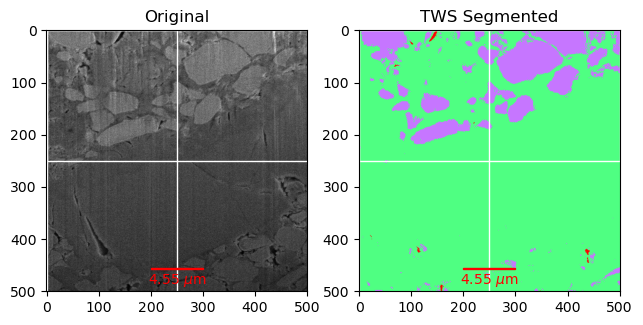

In [819]:
img = plt.imread("../unsegmented/000.tif")
img_tws = plt.imread("../segmented/000.tif")
img_tws2 = np.asarray(Image.open("../segmented/000.tif")).reshape(501, 501)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img, cmap='gray')
rect0 = patches.Rectangle((0, 0), 501, 250, edgecolor='w', fill=False)
rect1 = patches.Rectangle((0, 0), 501, 250, edgecolor='w', fill=False)
rect2 = patches.Rectangle((0, 0), 250, 501, edgecolor='w', fill=False)
rect3 = patches.Rectangle((0, 0), 250, 501, edgecolor='w', fill=False)
scalebar0 = AnchoredSizeBar(ax[0].transData,
                           100, r'4.55 $\mu$m', 'lower center', 
                           pad=0.1,
                           color='red',
                           frameon=False,
                           size_vertical=1
                           )
scalebar1 = AnchoredSizeBar(ax[1].transData,
                           100, r'4.55 $\mu$m', 'lower center', 
                           pad=0.1,
                           color='red',
                           frameon=False,
                           size_vertical=1
                           )

ax[0].add_artist(scalebar0)
ax[0].add_patch(rect0)
ax[0].add_patch(rect2)
ax[0].set_title("Original")

ax[1].imshow(img_tws, cmap='gray')
ax[1].add_patch(rect1)
ax[1].add_patch(rect3)
ax[1].add_artist(scalebar1)
ax[1].set_title("TWS Segmented")

plt.savefig("../figures/tws-segmented.png", dpi=500, pad_inches=0);
plt.tight_layout();

### Utility Functions

In [820]:
def load_clusters(X_2d, y_predict):
    img_seg = -2 * np.ones(img.shape)
    for v in np.unique(y_predict):
        X_v = np.argwhere(y_predict == v)
        coords = list(itertools.chain.from_iterable(X_v))
        for coord in coords:
            xx, yy = X_2d[int(coord), :2]
            img_seg[int(xx), int(yy)] = v
    return img_seg

In [821]:
def enhance_clusters(img_seg):
    new_img = -2 * np.ones(img_seg.shape)
    for i in range(img_seg.shape[0]):
        for j in range(img_seg.shape[1]):
            v = img_seg[i, j]
            if v != -2:
                new_img[i, j] = v
                continue
            neighs = [
                (i, j + 1),
                (i + 1, j),
                (i, j - 1),
                (i - 1, j),
                (i + 1, j + 1),
                (i - 1, j - 1),
                (i - 1, j + 1),
                (i + 1, j - 1),
                ]
            vals = []
            for neigh in neighs:
                try:
                    vals.append(img_seg[neigh])
                except IndexError:
                    continue
            set_vals = set(vals)
            if -2 in set_vals:
                set_vals.remove(-2)
            if len(set_vals) == 1:
                new_img[i, j] = set_vals.pop()
    
    return new_img

In [822]:
def neighborhood_average(arr, d=(1, 1), n_min=(0, 0), n_max=(501, 501)):
    out = np.zeros(arr.shape)
    dx, dy = d
    for i in range(n_max[0]):
        for j in range(n_max[1]):
            val = arr[i, j]
            neighbors = arr[max(i - dx, 0):min(i + dx, n_max[0] - 1), max(j - dy, 0):min(j + dy, n_max[1] - 1)]
            out[i, j] = np.mean(neighbors)
    return out


def neighborhood_mode(arr, d=(1, 1), n_min=(0, 0), n_max=(501, 501)):
    out = np.zeros(arr.shape)
    dx, dy = d
    for i in range(n_max[0]):
        for j in range(n_max[1]):
            val = arr[i, j]
            neighbors = arr[max(i - dx, 0):min(i + dx, n_max[0] - 1), max(j - dy, 0):min(j + dy, n_max[1] - 1)]
            out[i, j] = np.mode(neighbors)[0][0]
    return out

In [823]:
def center_of_mass(arr):
    xcom = np.average(arr[:, 0])
    ycom = np.average(arr[:, 1])
    return xcom, ycom

### Edges

#### Input Image as 2D Data

In [929]:
NX = 501
NY = 501
NZ = 202

In [825]:
img_no = '201'
img_1 = cv2.imread(f"../unsegmented/{img_no}.tif", cv2.IMREAD_UNCHANGED)
img_2 = filters.meijering(img_1)

#### Edges from Meijering Filter

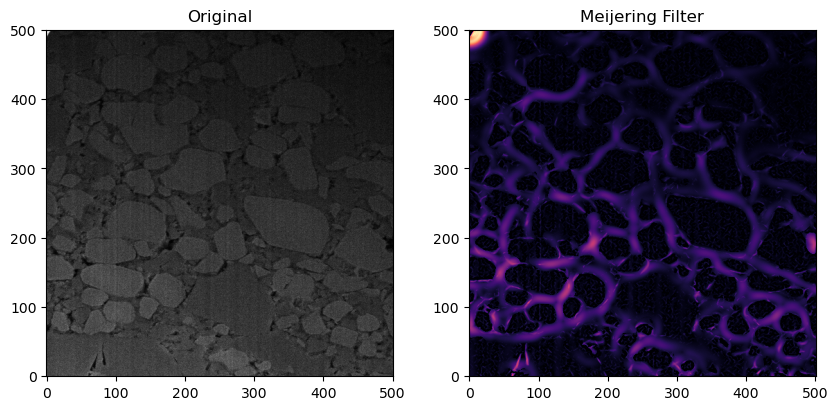

In [826]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_1, cmap='gray')
ax[0].invert_yaxis();
ax[0].set_title('Original');
ax[1].imshow(img_2, cmap='magma');
ax[1].invert_yaxis();
ax[1].set_title('Meijering Filter');

#### Enhancement via Local Averaging

In [827]:
img_3 = neighborhood_average(img_2)
img_3 = neighborhood_average(img_3)
img_3 = neighborhood_average(img_3)
img_3 = neighborhood_average(img_3)
img = img_3 / np.max(img_3)

In [828]:
threshold = 0.075 #- 0.05 * (int(img_no) + 1) / NZ
coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
y = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
X_2d = np.hstack((coords, y))

### HDBSCAN Clustering

#### Optimal Threshold

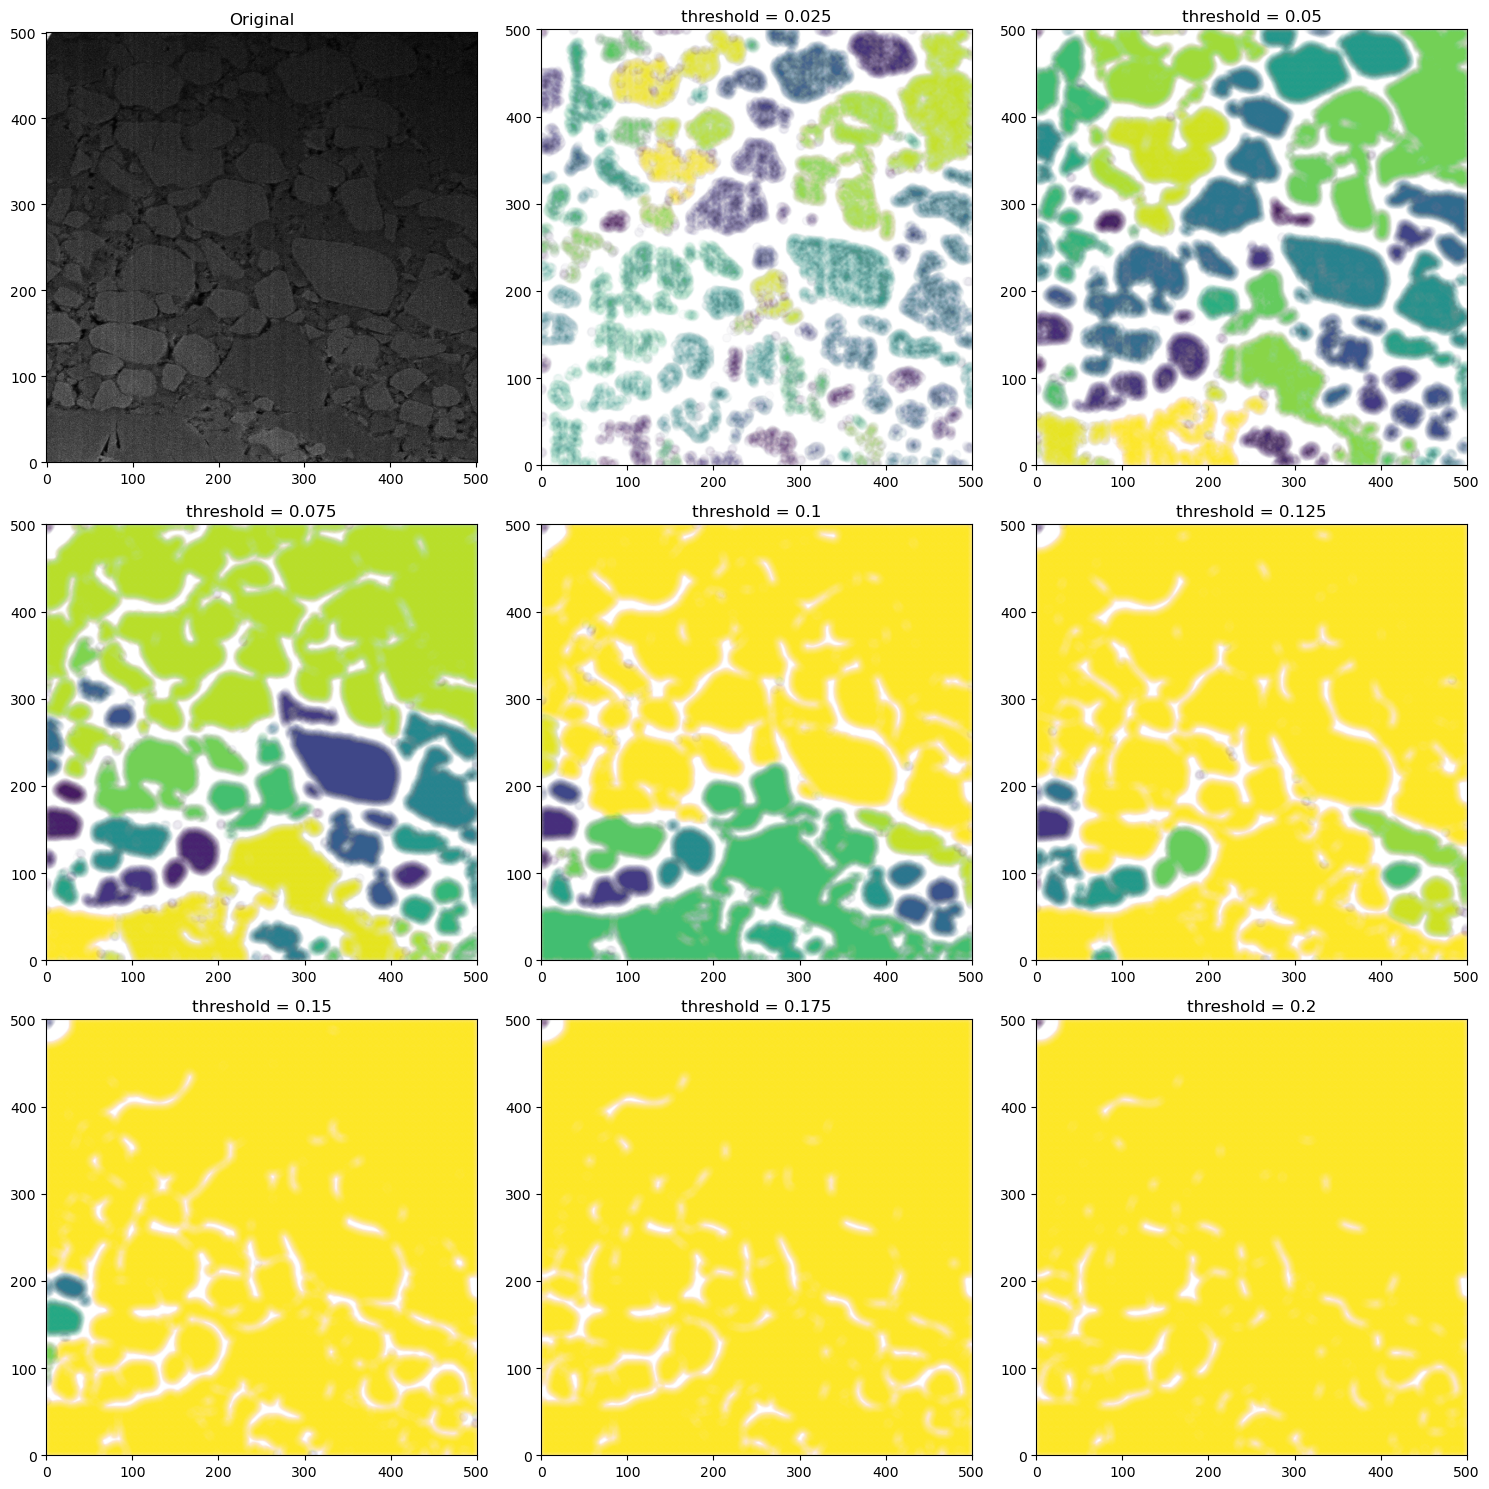

In [829]:
thresholds = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax[0, 0].imshow(img_1, cmap='gray')
ax[0, 0].invert_yaxis();
ax[0, 0].set_title('Original');
for idx, threshold in enumerate(thresholds):
    coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
    y = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
    X_2d = np.hstack((coords, y))

    # hdbscan
    clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=5, gen_min_span_tree=True)
    y_predict = clusterer.fit_predict(X_2d).reshape(-1, 1)

    # results
    ix = int((idx + 1) / 3)
    iy = (idx + 1) % 3
    ax[ix, iy].scatter(X_2d[:, 1], X_2d[:, 0], c=y_predict, alpha=0.01)
    ax[ix, iy].set_title(f"threshold = {threshold}");
    ax[ix, iy].set_xlim([0, 500]);
    ax[ix, iy].set_ylim([0, 500]);
plt.tight_layout();

### Segmentation
* Use optimal threshold to select feature points for clusters
* Identify clusters using hdbscan
* Backfill missing values in clusters to ensure dense cluster without small holes
* Use clusters to label training data
* Update training data with void clusters information
* Deploy model using the training data in order to predict the whole image

#### 1. Void Phase

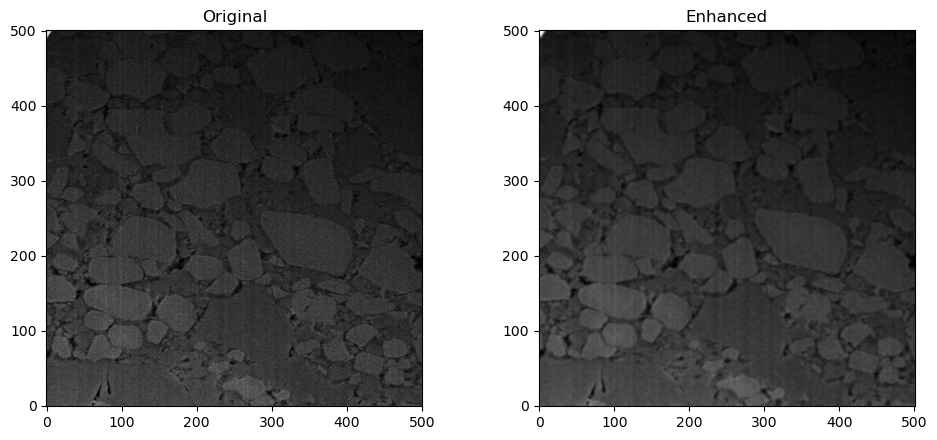

In [830]:
img_1 = cv2.imread(f"../unsegmented/{img_no}.tif", cv2.IMREAD_UNCHANGED)
img_2 = neighborhood_average(img_1 / 255)
for i in range(3):
    img_2 = neighborhood_average(img_2)

fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_1, cmap='gray');
ax[0].invert_yaxis();
ax[0].set_title('Original');
ax[1].imshow(img_2, cmap='gray');
ax[1].invert_yaxis();
ax[1].set_title(f"Enhanced");
plt.tight_layout();

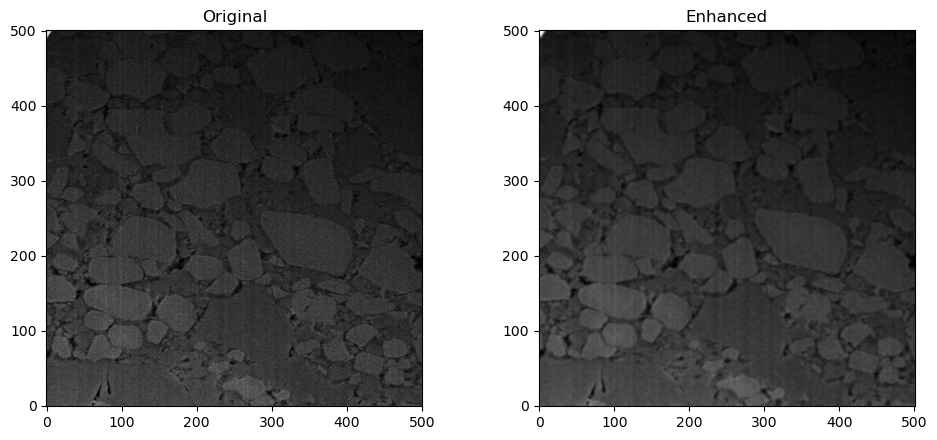

In [831]:
img_3 = (img_2 - np.min(img_2)) / (np.max(img_2) - np.min(img_2))
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_1, cmap='gray');
ax[0].invert_yaxis();
ax[0].set_title('Original');
ax[1].imshow(img_3, cmap='gray');
ax[1].invert_yaxis();
ax[1].set_title(f"Enhanced");

plt.tight_layout();

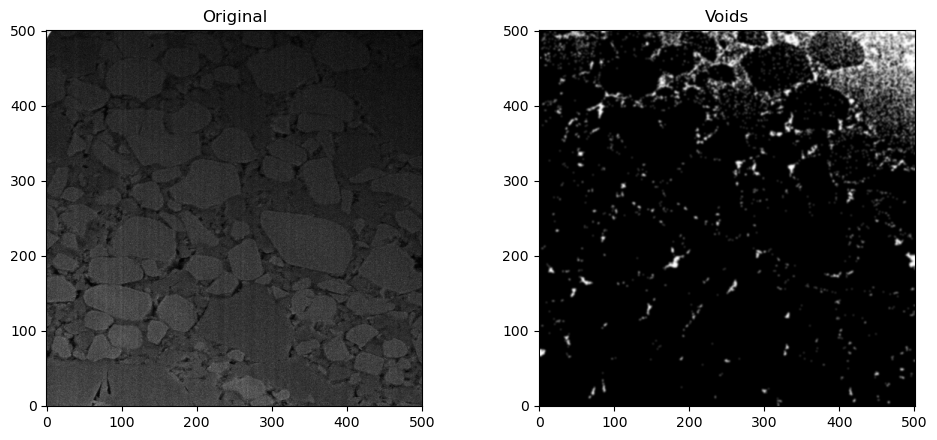

In [832]:
for i in range(5):
    img_3 = neighborhood_average(img_3)
voids = (img_1 / 255) < 0.075
for i in range(5):
    voids = neighborhood_average(voids)
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_1, cmap='gray');
ax[0].invert_yaxis();
ax[0].set_title('Original');
ax[1].imshow(voids, cmap='gray');
ax[1].invert_yaxis();
ax[1].set_title(f"Voids");
plt.tight_layout();

#### Non-void Single-Phase Clusters

In [833]:
threshold = 0.075 - 0.05 * (int(img_no) + 1) / NZ
coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
y = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
X_2d = np.hstack((coords, y))

clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=2, gen_min_span_tree=True)
y_predict = clusterer.fit_predict(X_2d).reshape(-1, 1)

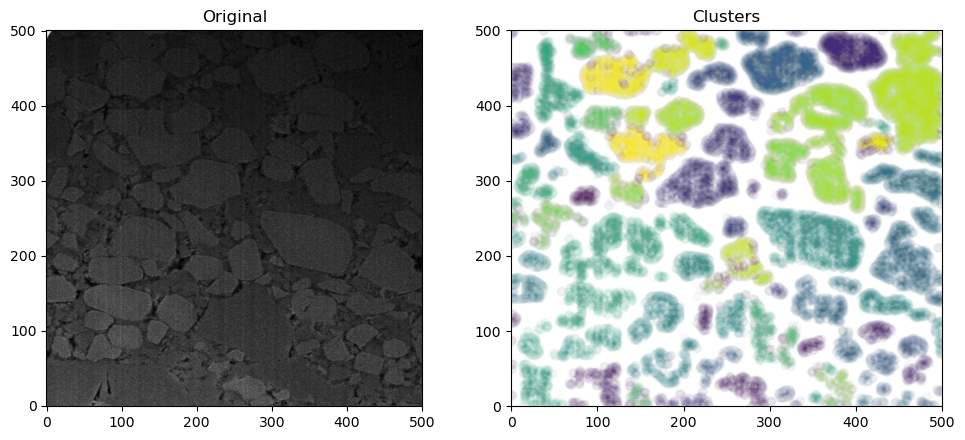

In [834]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_1, cmap='gray')
ax[0].invert_yaxis();
ax[1].scatter(X_2d[:, 1], X_2d[:, 0], c=y_predict, alpha=0.01)
ax[0].set_title('Original');
ax[1].set_title(f"Clusters");
ax[1].set_xlim([0, 500]);
ax[1].set_ylim([0, 500]);
plt.tight_layout();

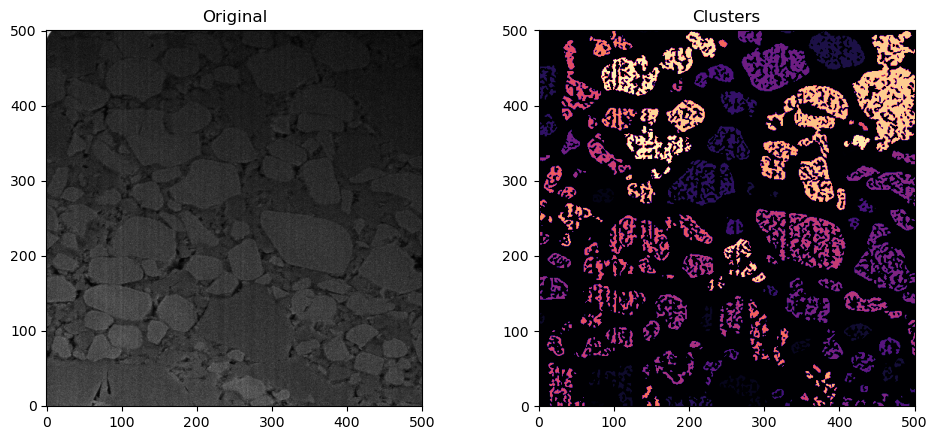

In [835]:
img_seg = -2 * np.ones(img.shape)

averages = []
for v in np.unique(y_predict):
    X_v = np.argwhere(y_predict == v)
    coords = list(itertools.chain.from_iterable(X_v))
    for coord in coords:
        xx, yy = X_2d[int(coord), :2]
        img_seg[int(xx), int(yy)] = v
    px_avg = np.mean(y[X_v])
    averages.append(px_avg)

fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_1, cmap='gray')
ax[0].invert_yaxis();
ax[1].imshow(img_seg, cmap='magma')
ax[0].set_title('Original');
ax[1].set_title(f"Clusters");
ax[1].set_xlim([0, 500]);
ax[1].set_ylim([0, 500]);
plt.tight_layout();

(array([ 28.60493812,  14.30246906,  57.20987624,  71.5123453 ,
       128.72222153, 357.56172648, 672.21604578, 185.93209777,
       143.02469059,  28.60493812]), array([0.01237923, 0.01297176, 0.01356429, 0.01415681, 0.01474934,
       0.01534186, 0.01593439, 0.01652691, 0.01711944, 0.01771196,
       0.01830449]), <BarContainer object of 10 artists>)


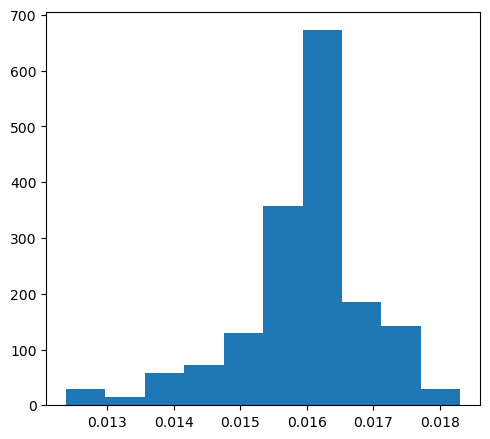

In [836]:
fig, ax = plt.subplots(figsize=(5, 4.5))
bins = ax.hist(averages, bins=10, density=True);
plt.tight_layout();
print(bins)

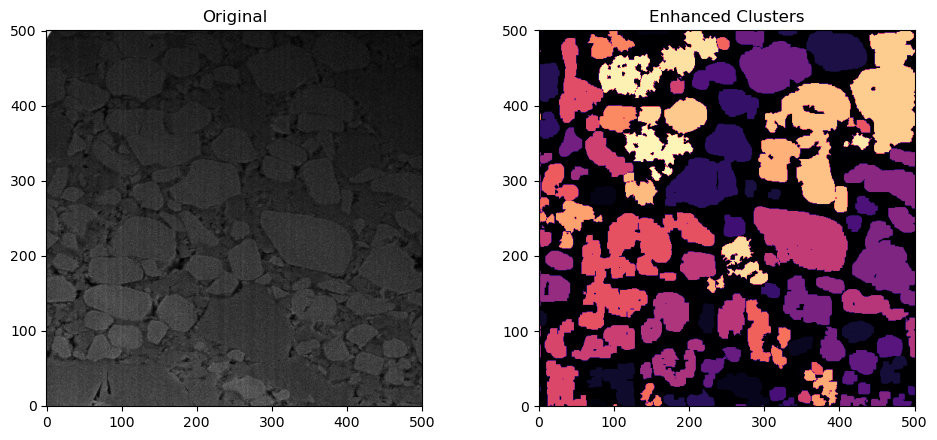

In [837]:
new_img = enhance_clusters(img_seg)
for i in range(2):
    new_img = enhance_clusters(new_img)

fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_1, cmap='gray')
ax[0].invert_yaxis();
ax[0].set_title('Original');
ax[1].imshow(new_img, cmap='magma')
ax[1].set_title(f"Enhanced Clusters");
ax[1].set_xlim([0, 500]);
ax[1].set_ylim([0, 500]);
plt.tight_layout();

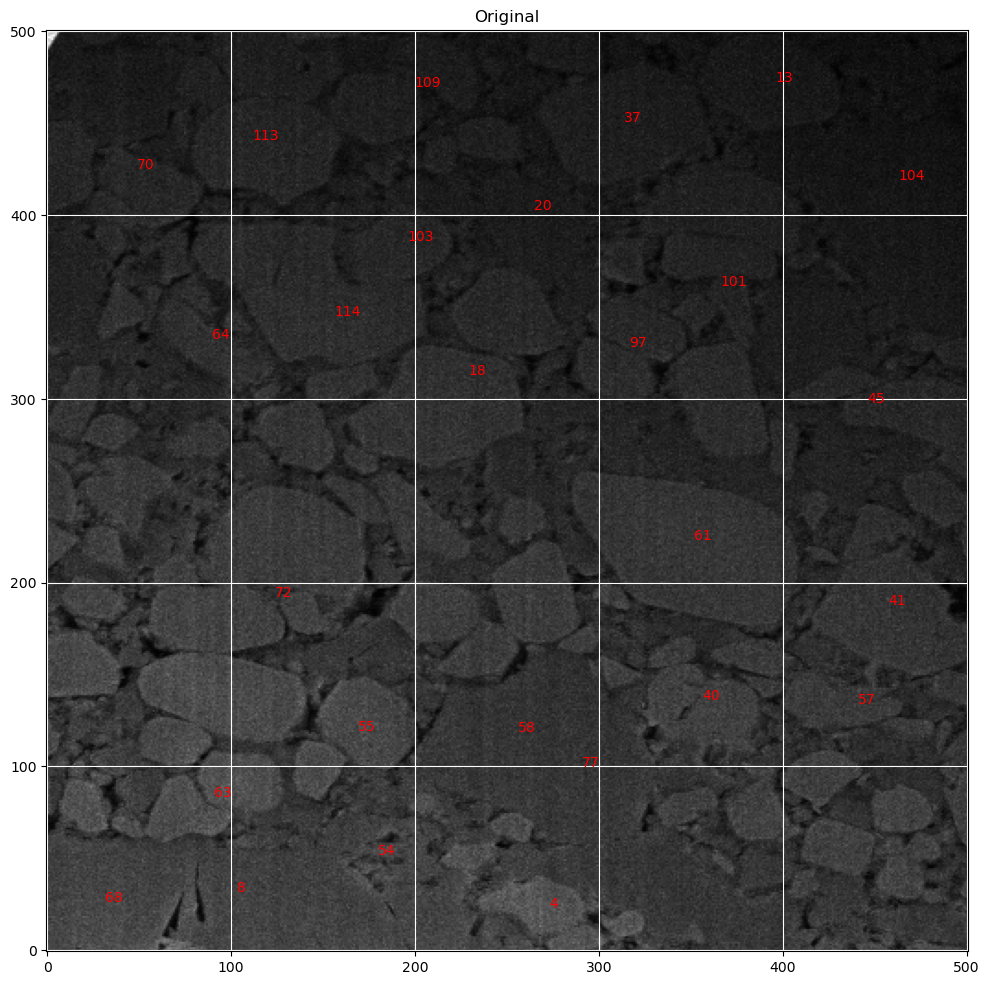

In [838]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_1, cmap='gray')
ax.invert_yaxis();
ax.grid(which='both', c='white')
ax.set_title('Original');

for v in np.unique(new_img):
    if v in (-1, -2):
        continue
    coords = np.argwhere(new_img == v)
    values = np.array([img_1[tuple(c)] for c in coords]).reshape(-1, 1) / 255
    len_cluster = coords.shape[0]
    if len_cluster < 1500:
        continue
    px_avg = np.mean(values)
    px5 = np.percentile(values, 5)
    px25 = np.percentile(values, 25)
    px75 = np.percentile(values, 75)
    px95 = np.percentile(values, 95)
    xcom, ycom = center_of_mass(coords)
    ax.text(ycom, xcom, int(v), c='red')
    plt.tight_layout();

#### Label Training Images

<IPython.core.display.Javascript object>


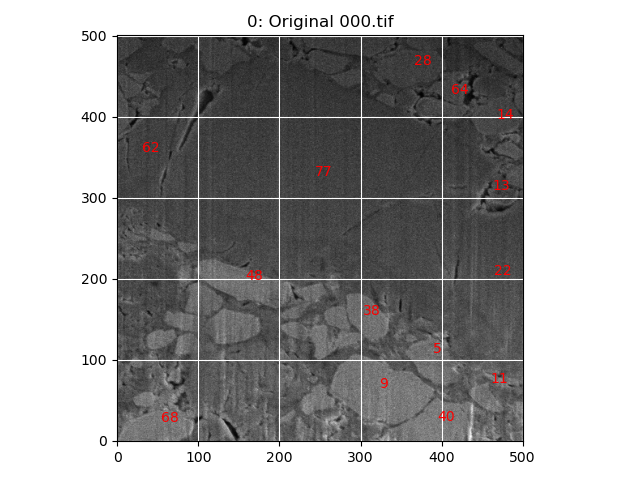

<IPython.core.display.Javascript object>


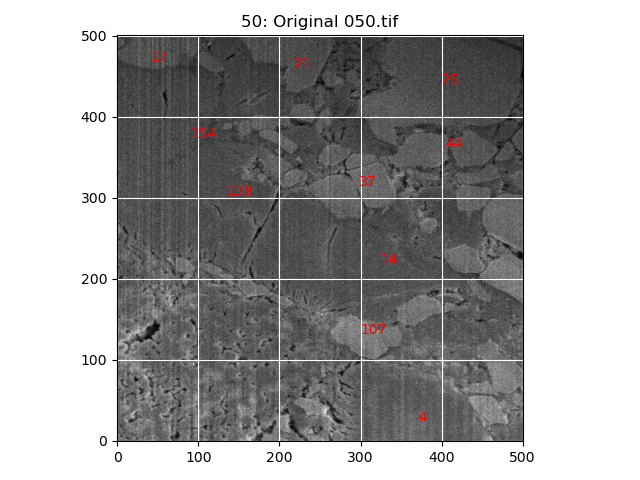

<IPython.core.display.Javascript object>


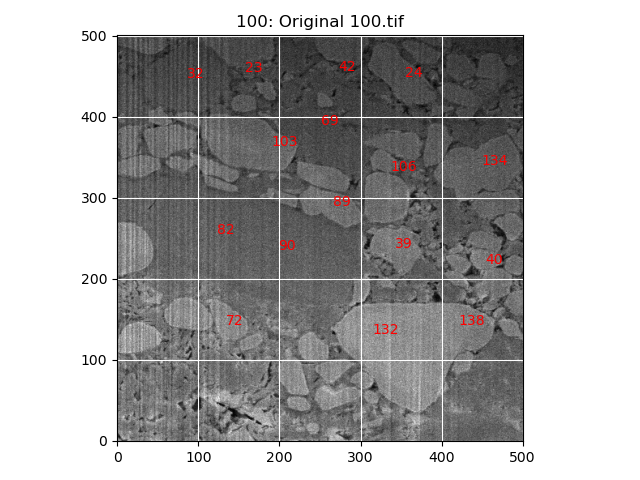

<IPython.core.display.Javascript object>


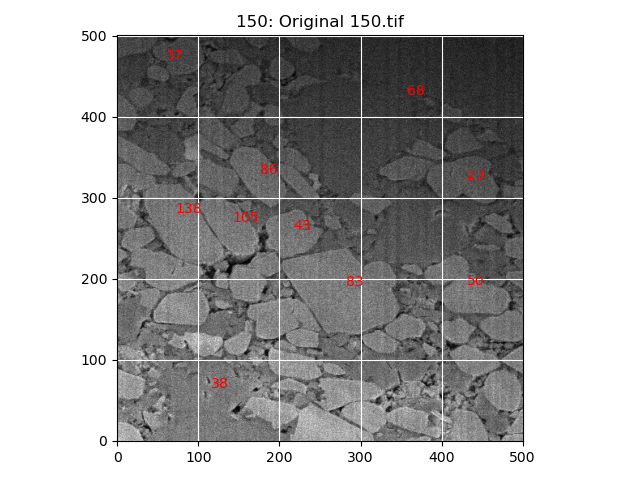

<IPython.core.display.Javascript object>


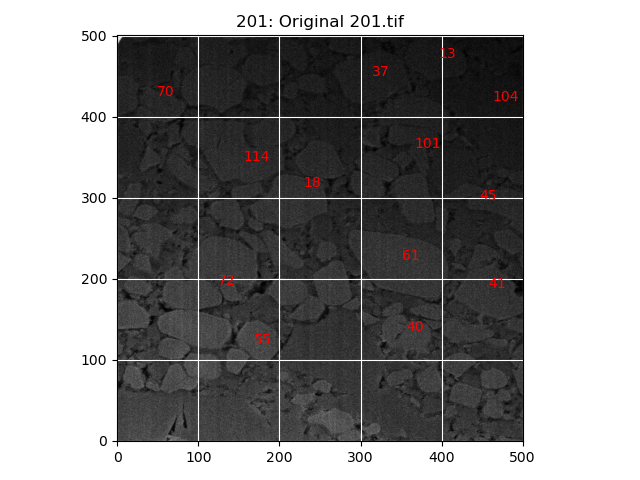

In [1012]:
training_images = ['000.tif', '050.tif', '100.tif', '150.tif', '201.tif']
NX = 501
NY = 501
NZ = 202
training = defaultdict(lambda: [])

for train_image in training_images:
    z = int(train_image.split('.')[0])

    # input data
    img_1 = cv2.imread("../unsegmented/" + train_image, cv2.IMREAD_UNCHANGED)
    img_2 = filters.meijering(img_1)
    img_3 = neighborhood_average(img_2)
    img_3 = neighborhood_average(img_3)
    img_3 = neighborhood_average(img_3)
    img_3 = neighborhood_average(img_3)
    img = img_3 / np.max(img_3)
    
    # original
    fig, ax = plt.subplots()
    ax.imshow(img_1, cmap='gray')
    ax.invert_yaxis();
    ax.set_title(f'{z}: Original {train_image}');
    ax.grid(which='both', c='white');

    # features
    threshold = 0.075 - 0.05 * (z + 1) / NZ
    coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
    y = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
    X_2d = np.hstack((coords, y))

    # hdbscan
    clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=2, gen_min_span_tree=True)
    y_predict = clusterer.fit_predict(X_2d).reshape(-1, 1)

    # enhance clusters
    img_seg = load_clusters(X_2d, y_predict)
    new_img = enhance_clusters(img_seg)
    for i in range(2):
        new_img = enhance_clusters(new_img)
    
    # big enough clusters
    clusters = []
    for v in np.unique(new_img):
        if v in (-1, -2):
            continue
        #
        coords = np.argwhere(new_img == v)
        values = np.array([img_1[tuple(c)] for c in coords]).reshape(-1, 1) / 255
        len_cluster = coords.shape[0]
        if len_cluster < 2500:
            continue
        px_avg = np.mean(values)
        pct1 = np.percentile(values, 1)
        pct25 = np.percentile(values, 25)
        pct75 = np.percentile(values, 75)
        pct99 = np.percentile(values, 99)
        std = np.std(values)
        ycom, xcom = center_of_mass(coords)
        ax.text(xcom, ycom, int(v), c='red');
        phase = -2
        df_row = {"dummy_cluster_id": int(v), "xcom": xcom, 'ycom': ycom, 'zcom': z, 'px_avg': px_avg, 'pct1': pct1, 'pct25': pct25, 'pct75': pct75, 'pct99': pct99, 'std': std, 'phase': phase}
        training[z].append(df_row)
    plt.tight_layout();
    plt.show();

Now, from the plots label the training data into correct phases.

In [840]:
df_train = pd.DataFrame(
    {"xcom": [], 'ycom': [], 'zcom': [], 'px_avg': [], 'pct1': [], 'pct25': [], 'pct75': [], 'pct99': [], 'std': [], 'phase': []}
)

In [1013]:
# image 0
phases = {
    0: {
        1: [62,  77, 22],
        2: [68, 9, 40, 11, 5, 23, 37, 38, 48, 86, 45, 44, 28, 64, 15, 14],
    },
        0: {
        1: [62,  77, 22],
        2: [68, 9, 40, 11, 5, 23, 37, 38, 48, 86, 45, 44, 28, 64, 15, 14],
    },
    50: {
        1: [157, 45, 154, 138, 141, 14, 4],
        2: [17, 21, 25, 44, 37, 124, 64, 63, 107, 79],
    },
    100: {
        1: [32, 69, 46, 116, 82, 90, 81, 15],
        2: [24, 29, 28, 36, 103, 43, 106, 134, 0, 89, 39, 40, 2, 66, 72, 52, 132, 127, 138],
    },
    150: {
        1: [68, 38],
        2: [37, 90, 86, 22, 23, 138, 105, 43, 62, 31, 83, 50, 79, 75, 56],
    },
    201: {
        1: [20, 104, 58, 77, 68, 8],
        2: [70, 113, 109, 37, 13, 64, 114, 103, 18, 97, 101, 45, 72, 61, 41, 55, 40, 57, 63, 4],
    },
}
for k in phases.keys():
    phase1 = phases[k][1]
    phase2 = phases[k][2]
    zdata = training[k]
    for row in zdata:
        df_row = row.copy()
        dummy_cluster_id = df_row['dummy_cluster_id']
        del df_row['dummy_cluster_id']
        if dummy_cluster_id in phase1:
            df_row['phase'] = 1
        elif dummy_cluster_id in phase2:
            df_row['phase'] = 2
        else:
            continue
            df_row['phase'] = -2
        df_train = df_train.append(df_row, ignore_index=True)

#### Testing Data

In [842]:
df_test = pd.DataFrame(
    {"xcom": [], 'ycom': [], 'zcom': [], 'px_avg': [], 'pct1': [], 'pct25': [], 'pct75': [], 'pct99': [], 'std': [], 'phase': []}
)
for idx in range(15):
    print(idx)
    z = idx

    # input data
    fname = str(z).zfill(3) + ".tif"
    if fname in training_images:
        continue
    img_1 = cv2.imread("../unsegmented/" + fname, cv2.IMREAD_UNCHANGED)
    img_2 = filters.meijering(img_1)
    img_3 = neighborhood_average(img_2)
    img_3 = neighborhood_average(img_3)
    img_3 = neighborhood_average(img_3)
    img_3 = neighborhood_average(img_3)
    img = img_3 / np.max(img_3)

    # features
    threshold = 0.075 - 0.01 * (z + 1) / NZ
    coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
    y = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
    X_2d = np.hstack((coords, y))

    # hdbscan
    clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=2, gen_min_span_tree=True)
    y_predict = clusterer.fit_predict(X_2d).reshape(-1, 1)

    # enhance clusters
    img_seg = load_clusters(X_2d, y_predict)
    new_img = enhance_clusters(img_seg)
    for i in range(2):
        new_img = enhance_clusters(new_img)

    # big enough clusters
    clusters = []
    for v in np.unique(new_img):
        if v in (-1, -2):
            continue
        #
        coords = np.argwhere(new_img == v)
        values = np.array([img_1[tuple(c)] for c in coords]).reshape(-1, 1)
        len_cluster = coords.shape[0]
        if len_cluster < 1500:
            continue
        px_avg = np.mean(values)
        pct1 = np.percentile(values, 1)
        pct25 = np.percentile(values, 25)
        pct75 = np.percentile(values, 75)
        pct99 = np.percentile(values, 99)
        std = np.std(values)
        ycom, xcom = center_of_mass(coords)
        phase = -2
        df_row = {"xcom": xcom, 'ycom': ycom, 'zcom': z, 'px_avg': px_avg, 'pct1': pct1, 'pct25': pct25, 'pct75': pct75, 'pct99': pct99, 'std': std, 'phase': phase}
        df_test = df_test.append(df_row, ignore_index=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


In [843]:
X_train = df_train[[c for c in df_train.columns if c not in ['phase']]].values
X_train[:, [0, 1]] = X_train[:, [0, 1]] / (NX - 1)
X_train[:, 2] = X_train[:, 2] / (NZ - 1)
X_train[:, 3:] = X_train[:, 3:] / 255

y_train = df_train['phase'].values.reshape(-1, 1)

X_test = df_test[[c for c in df_test.columns if c  not in ['phase']]].values
y_test = df_test['phase'].values.reshape(-1, 1)
X_test[:, [0, 1]] = X_test[:, [0, 1]] / (NX - 1)
X_test[:, 2] = X_test[:, 2] / (NZ - 1)
X_test[:, 3:] = X_test[:, 3:] / 255

#### Classifying Unsegmented Single-Phase Clusters
##### Decision Tree Classifier

In [844]:
# dtc = DecisionTreeClassifier()
# dtc.fit(X_train, y_train)
# y_predict = dtc.predict(X_test)
# print(dtc.score(X_train, y_train))

##### Random Forest Classifier

In [912]:
clf = RandomForestClassifier(class_weight='balanced', criterion='entropy')
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print(clf.score(X_train, y_train))

1.0


##### MLP Classifier

In [913]:
# clf = MLPClassifier(max_iter=300)
# clf.fit(X_train, y_train)
# y_predict = clf.predict(X_test)
# print(clf.score(X_train, y_train))

##### SVC

In [914]:
# svc = SVC(kernel='rbf',gamma=1e-3, C=1000)
# svc.fit(X_train, y_train)
# y_predict = svc.predict(X_test)

##### kNN

In [915]:
# knn = KNeighborsClassifier(n_neighbors=4)
# knn.fit(X_train, y_train)
# y_predict = knn.predict(X_test)

##### naive Bayes

In [916]:
# NB = ComplementNB()
# NB.fit(X_train, y_train)
# y_predict = NB.predict(X_test)

In [917]:
# clf = HistGradientBoostingClassifier()
# clf.fit(X_train, y_train)
# y_predict = clf.predict(X_test)

In [918]:
# clf = AdaBoostClassifier()
# clf.fit(X_train, y_train)
# y_predict = clf.predict(X_test)

In [919]:
# clf = ExtraTreesClassifier()
# clf.fit(X_train, y_train)
# y_predict = clf.predict(X_test)

In [920]:
df_test['phase'] = y_predict

In [921]:
# print(df_test[['xcom', 'ycom', 'zcom', 'px_avg', 'phase']])
# hdbscan
# clusterer = hdbscan.HDBSCAN(min_cluster_size=5, cluster_selection_epsilon=50, gen_min_span_tree=True)
# y_predict = clusterer.fit_predict(X_test).reshape(-1, 1)
# print(y_predict[np.where(X_test[:, 2] == 5.0)], X_test[np.where(X_test[:, 2] == 5.0), -1])
# nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree')
# nrbs.fit(X_test)


In [922]:
test_img_no = 1
slice5 = df_test[df_test['zcom'] == test_img_no]
x5 = slice5['xcom']
y5 = slice5['ycom']
slice5

xcom        ycom  zcom      px_avg   pct1  pct25  pct75   pct99  \
0   456.596626  455.244888   1.0   46.080266  20.00   39.0   50.0  102.90   
1   269.151448  459.321084   1.0   49.001856  25.00   43.0   55.0   69.00   
2   287.575811  442.447415   1.0   53.504820  36.00   45.0   56.0  113.00   
3    22.110984  424.243016   1.0   55.529659  27.12   48.0   64.0   82.00   
4   111.692624  466.178854   1.0   51.325419  25.00   45.0   56.0   97.00   
5   175.771429   48.736327   1.0   95.644490  45.98   81.0  107.0  164.00   
6    19.148331  338.549753   1.0   54.399258  38.00   49.0   59.0   74.00   
7   367.971131  466.043777   1.0   49.087553  25.25   44.0   55.0   68.00   
8   167.096399  252.097507   1.0   57.209418  41.04   52.0   62.0   78.00   
9   378.342095  101.748079   1.0   89.973716  61.00   83.0   97.0  119.28   
10   69.567287   39.112144   1.0  105.136761  34.00   91.0  120.0  174.00   
11  469.497207  322.485413   1.0   60.851024  28.10   53.0   68.0   92.00   
12  392.067812  409.385624   1.0   54.585443  16.00   49.0   62.0   77.00   
13  242.126468  335.668050   1.0   52.766018  33.00   47.0   58.0   76.00   
14   66.946336  247.353973   1.0   74.999484  40.00   65.0   85.0  113.00   
15  311.297894  154.457372   1.0   87.621866  39.00   81.0   96.0  115.00   
16  389.317487   24.232741   1.0   98.411327  76.00   92.0  105.0  120.00   
17  456.933972  211.922757   1.0   60.761593  44.00   55.0   66.0   83.65   
18  341.565255   62.470657   1.0   96.761460  68.00   90.0  104.0  121.00   
19  469.071309  397.587744   1.0   57.076880  40.00   52.0   62.0   76.00   

          std  phase  
0   13.638901    2.0  
1    9.256611    2.0  
2   14.734555    2.0  
3   11.836638    2.0  
4   11.027140    2.0  
5   23.165838    2.0  
6    7.691562    2.0  
7    8.704509    2.0  
8    7.489118    2.0  
9   11.828046    2.0  
10  26.723909    2.0  
11  12.198601    2.0  
12  11.311727    2.0  
13   8.773916    2.0  
14  14.887937    2.0  
15  13.319673    2.0  
16   9.614989    2.0  
17   8.429282    2.0  
18  10.673169    2.0  
19   7.473906    2.0

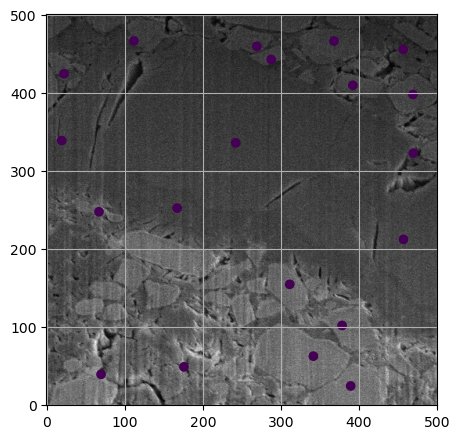

In [923]:
img_01 = cv2.imread('../unsegmented/{}.tif'.format(str(int(test_img_no)).zfill(3)), cv2.IMREAD_UNCHANGED)
fig, ax = plt.subplots(figsize=(5, 4.5))
ax.imshow(img_01, cmap='gray');
ax.invert_yaxis();
ax.grid();
ax.scatter(x5, y5, c=slice5['phase']);
plt.tight_layout();
plt.show();

#### 3D Clustering

In [1000]:
# n_files = min(6, NZ)
# data3d = -100 * np.ones((NX, NY, n_files))

# for idx in range(6):
#     z = idx
#     # input data
#     fname = str(z).zfill(3) + ".tif"
#     print(fname)
#     img_1 = np.array(cv2.imread("../unsegmented/" + fname, cv2.IMREAD_UNCHANGED))
#     img_2 = np.array(filters.meijering(img_1))
#     img_3 = neighborhood_average(img_2)
#     img_3 = neighborhood_average(img_3)
#     img_3 = neighborhood_average(img_3)
#     img_3 = neighborhood_average(img_3)
#     img = img_3 / np.max(img_3)

#     # features
#     threshold = 0.075 - 0.01 * (z + 1) / NZ
#     coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
#     y = np.array([img_1[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1) / 255
#     X_2d = np.hstack((coords, y))

#     # hdbscan
#     clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=2, gen_min_span_tree=True)
#     y_predict = clusterer.fit_predict(X_2d).reshape(-1, 1)

#     # enhance clusters
#     img_seg = load_clusters(X_2d, y_predict)
#     new_img = enhance_clusters(img_seg)
#     for i in range(2):
#         new_img = enhance_clusters(new_img)

#     # big enough clusters
#     clusters = []
#     for v in np.unique(new_img):
#         if v in (-1, -2):
#             continue
#         #
#         coords = np.argwhere(new_img == v)
        
#         values = np.array([img_1[tuple(c)] for c in coords]).reshape(-1, 1)
#         len_cluster = coords.shape[0]
#         if len_cluster < 1500:
#             continue
#         for c in coords:
#             data3d[c[0], c[1], z] = img_1[c[0], c[1]]

000.tif
001.tif
002.tif
003.tif
004.tif
005.tif


In [1001]:
# coords3 = np.argwhere(data3d != -100)
# print(coords3.shape)
# y3 = np.array([data3d[tuple(c)] for c in coords3]).reshape(-1, 1)
# X_3d = np.hstack((coords3, y3))

(744738, 3)


In [1002]:
# data3d = None

In [1003]:
# clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=2, gen_min_span_tree=True)
# y3_predict = clusterer.fit_predict(X_3d).reshape(-1, 1)

In [1004]:
# y3_predict.shape

(744738, 1)

In [1005]:
# print(np.unique(y3_predict))

[-1  0  1]


In [1006]:
# import pickle
# X_3d.shape, y_predict.shape

((744738, 4), (125126, 1))

In [1007]:
# locs = np.where(y3_predict.reshape(-1) == 0)
# len0 = len(locs[0])
# data0 = X_3d[locs, :3].reshape(len0, 3)
# print(data0.shape)

(12539, 3)


In [1008]:
# locs1 = np.where(y3_predict.reshape(-1) == 1)
# len1 = len(locs1[0])
# data1 = X_3d[locs1, :3].reshape(len1, 3)

<IPython.core.display.Javascript object>


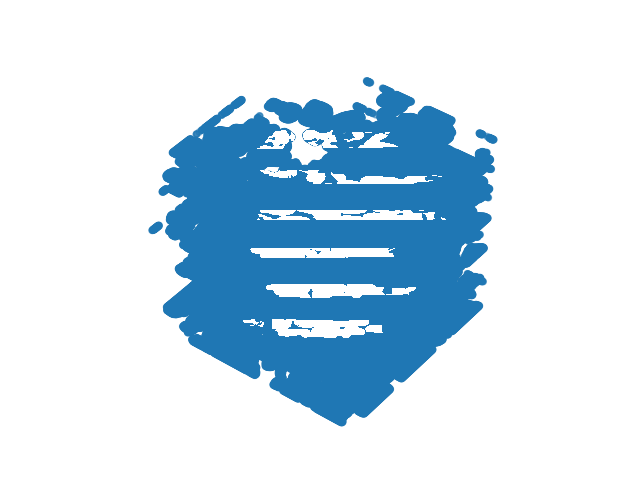

In [1009]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter3D(data1[:, 0], data1[:, 1], data1[:, 2], alpha=0.5);
# ax.set_axis_off();
# plt.tight_layout();

<IPython.core.display.Javascript object>


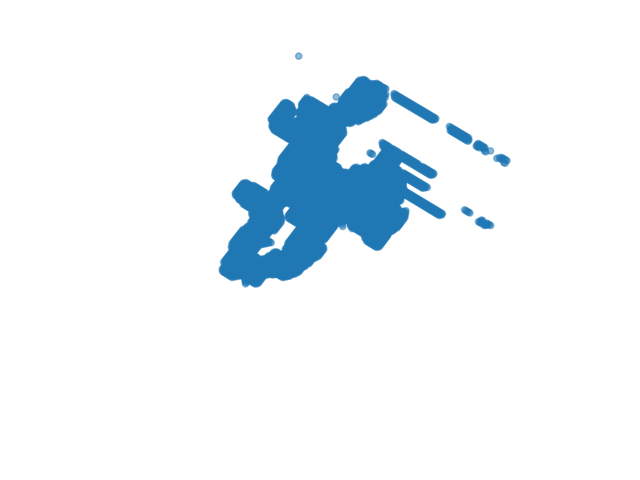

In [1010]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter3D(data0[:, 0], data0[:, 1], data0[:, 2], alpha=0.5);
# ax.set_axis_off();
# plt.tight_layout();